In [1]:
pip install tensorflow pandas numpy scikit-learn matplotlib


In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

In [29]:
import yfinance as yf
import pandas as pd

df = yf.download(
    tickers="AAPL",
    start="2021-01-01",
    end="2024-01-01",
    group_by="column",
    auto_adjust=False
)

df.reset_index(inplace=True)

df.columns = [
    col.lower() if isinstance(col, str) else col[0].lower()
    for col in df.columns
]

df.to_csv("stock.csv", index=False)

print(df.head())
print(df.columns)



[*********************100%***********************]  1 of 1 completed

        date   adj close       close        high         low        open  \
0 2021-01-04  125.974457  129.410004  133.610001  126.760002  133.520004   
1 2021-01-05  127.532013  131.009995  131.740005  128.429993  128.889999   
2 2021-01-06  123.239052  126.599998  131.050003  126.379997  127.720001   
3 2021-01-07  127.444389  130.919998  131.630005  127.860001  128.360001   
4 2021-01-08  128.544373  132.050003  132.630005  130.229996  132.429993   

      volume  
0  143301900  
1   97664900  
2  155088000  
3  109578200  
4  105158200  
Index(['date', 'adj close', 'close', 'high', 'low', 'open', 'volume'], dtype='object')


In [3]:
CSV_PATH = "stock.csv"
SEQ_LEN = 30
FORECAST_HORIZON = 7
BATCH_SIZE = 64
EPOCHS = 25
LR = 0.001
QUANTILES = [0.05, 0.5, 0.95]

In [4]:
def load_data(path):
    df = pd.read_csv(path, parse_dates=["date"])
    df.sort_values("date", inplace=True)

    df["log_return"] = np.log(df["close"]).diff()

    df["volatility"] = df["log_return"].rolling(10).std()

    df["volume_z"] = (df["volume"] - df["volume"].rolling(20).mean()) / \
                     df["volume"].rolling(20).std()

    df["dow"] = df["date"].dt.dayofweek
    df["dow_sin"] = np.sin(2 * np.pi * df["dow"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["dow"] / 7)

    df = df.dropna().reset_index(drop=True)
    return df

In [5]:
def make_sequences(data, seq_len):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len, :-1])
        y.append(data[i+seq_len, -1])
    return np.array(X), np.array(y)

In [6]:
def quantile_loss(q):
    def loss(y_true, y_pred):
        e = y_true - y_pred
        return tf.reduce_mean(tf.maximum(q * e, (q - 1) * e))
    return loss

In [7]:
def build_model(input_shape):
    inp = Input(shape=input_shape)

    x = LSTM(64, return_sequences=True)(inp)
    x = Dropout(0.2)(x)
    x = LSTM(64)(x)
    x = Dropout(0.2)(x)

    outputs = []
    for q in QUANTILES:
        outputs.append(Dense(1, name=f"q{int(q*100)}")(x))

    model = Model(inp, outputs)

    model.compile(
        optimizer=Adam(LR),
        loss={f"q{int(q*100)}": quantile_loss(q) for q in QUANTILES}
    )
    return model

In [8]:
def forecast(model, last_window, horizon):
    preds = []
    window = last_window.copy()

    for _ in range(horizon):
        q_preds = model.predict(window[np.newaxis, :, :], verbose=0)
        q_vals = np.array([q[0, 0] for q in q_preds])
        preds.append(q_vals)

        median = q_vals[1]
        next_step = np.zeros((1, window.shape[1]))
        next_step[0, 0] = median  # log_return position
        window = np.vstack([window[1:], next_step])

    return np.array(preds)

In [32]:
def main():
    df = load_data(CSV_PATH)

    features = [
        "log_return",
        "volatility",
        "volume_z",
        "dow_sin",
        "dow_cos"
    ]
    target = "log_return"

    data = df[features + [target]].values

    scaler = StandardScaler()
    data[:, :-1] = scaler.fit_transform(data[:, :-1])

    split = int(len(data) * 0.8)
    train_data = data[:split]
    test_data = data[split - SEQ_LEN:]

    X_train, y_train = make_sequences(train_data, SEQ_LEN)
    X_test, y_test = make_sequences(test_data, SEQ_LEN)

    model = build_model((SEQ_LEN, len(features)))
    model.summary()

    model.fit(
        X_train,
        {
            "q5": y_train,
            "q50": y_train,
            "q95": y_train
        },
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1
    )

    preds = model.predict(X_test)
    median_preds = preds[1].flatten()

    rmse = np.sqrt(mean_squared_error(y_test, median_preds))
    mae = mean_absolute_error(y_test, median_preds)

    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")

    last_window = test_data[-SEQ_LEN:, :-1]
    future = forecast(model, last_window, FORECAST_HORIZON)

    last_price = df["close"].iloc[-1]

    def returns_to_price(returns):
        prices = [last_price]
        for r in returns:
            prices.append(prices[-1] * np.exp(r))
        return prices[1:]

    median_price = returns_to_price(future[:, 1])
    lower_price = returns_to_price(future[:, 0])
    upper_price = returns_to_price(future[:, 2])

    future_dates = pd.date_range(
        df["date"].iloc[-1],
        periods=FORECAST_HORIZON+1,
        freq="B"
    )[1:]

    plt.figure(figsize=(12, 6))
    plt.plot(df["date"].iloc[-100:], df["close"].iloc[-100:], label="Historical")
    plt.plot(future_dates, median_price, label="Forecast", color="black")
    plt.fill_between(
        future_dates,
        lower_price,
        upper_price,
        alpha=0.3,
        label="Confidence Interval"
    )

    plt.title("Keras LSTM Probabilistic Forecast")
    plt.legend()
    plt.show()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 30, 64)    │     17,920 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q5 (Dense)          │ (None, 1)         │         65 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q50 (Dense)         │ (None, 1)         │         65 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ q95 (Dense)         │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 51,139 (199.76 KB)

 Trainable params: 51,139 (199.76 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - loss: 0.0480 - q50_loss: 0.0242 - q5_loss: 0.0131 - q95_loss: 0.0107
Epoch 2/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0249 - q50_loss: 0.0153 - q5_loss: 0.0055 - q95_loss: 0.0041
Epoch 3/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0222 - q50_loss: 0.0138 - q5_loss: 0.0043 - q95_loss: 0.0041
Epoch 4/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0188 - q50_loss: 0.0122 - q5_loss: 0.0034 - q95_loss: 0.0032
Epoch 5/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0163 - q50_loss: 0.0106 - q5_loss: 0.0032 - q95_loss: 0.0025
Epoch 6/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0155 - q50_loss: 0.0099 - q5_loss: 0.0029 - q95_loss: 0.0028
Epoch 7/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0148 - q50_loss: 0.0099 - q5_loss: 0.0026 - q95_loss: 0.0023
Epoch 8/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0148 - q50_loss: 0.0097 - q5_loss: 0.0027 - q95_loss: 0.0024
Epoch 9/25
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 4

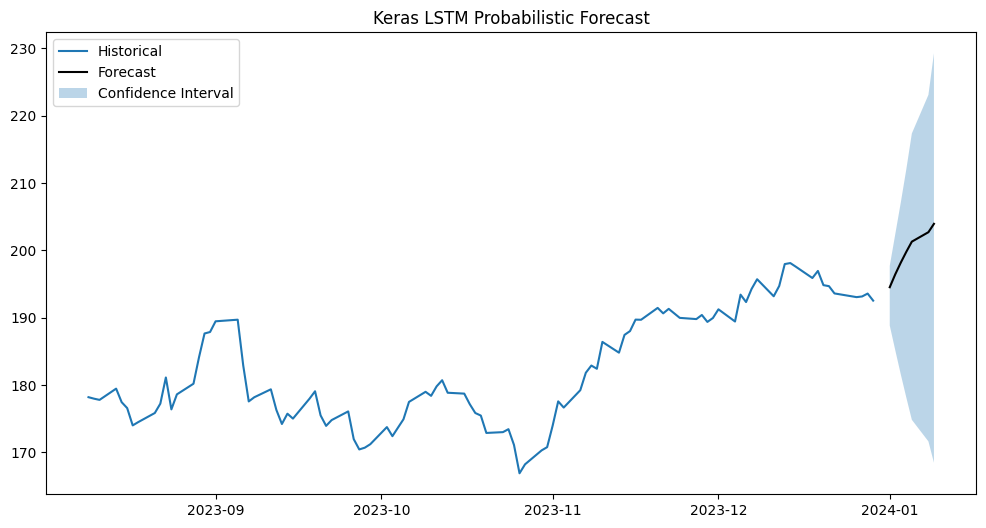

In [33]:
main()